## Toolbox

In [3]:
%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
# from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\ProgramData\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


### Cheatsheets

[Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#links)

[DataColor](https://learnui.design/tools/data-color-picker.html)

[LaTeX math](https://kapeli.com/cheat_sheets/LaTeX_Math_Symbols.docset/Contents/Resources/Documents/index)

[Python Beginner](file:///C:/Users/racco/Downloads/papers/beginners_python_cheat_sheet_pcc_all.pdf)

[Python Matplotlib](file:///C:/Users/racco/Downloads/papers/Python_Matplotlib_Cheat_Sheet.pdf)

[Python Numpy](file:///C:/Users/racco/Downloads/papers/Numpy_Python_Cheat_Sheet.pdf)

[Python Pandas](file:///C:/Users/racco/Downloads/papers/Python_Pandas_Cheat_Sheet_2.pdf)

[Python Scipy](file:///C:/Users/racco/Downloads/papers/Python_SciPy_Cheat_Sheet_Linear_Algebra.pdf)


### Data processing scripts

In [3]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [4]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], 
                                                     index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], 
                                                     index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

### Plotting

#### Update and flush inline outputs

In [5]:
import sys, time

N = 100
for j in range(int(N/30)):
    for i in range(N):
       time.sleep(0.05)
       sys.stdout.flush()
#        sys.stdout.write("\r{:.1f} %".format(i/N*100))
       print("{:.1f} %".format(i/N*100), end="\r")

#### Quick viewing DC results

<IPython.core.display.Javascript object>


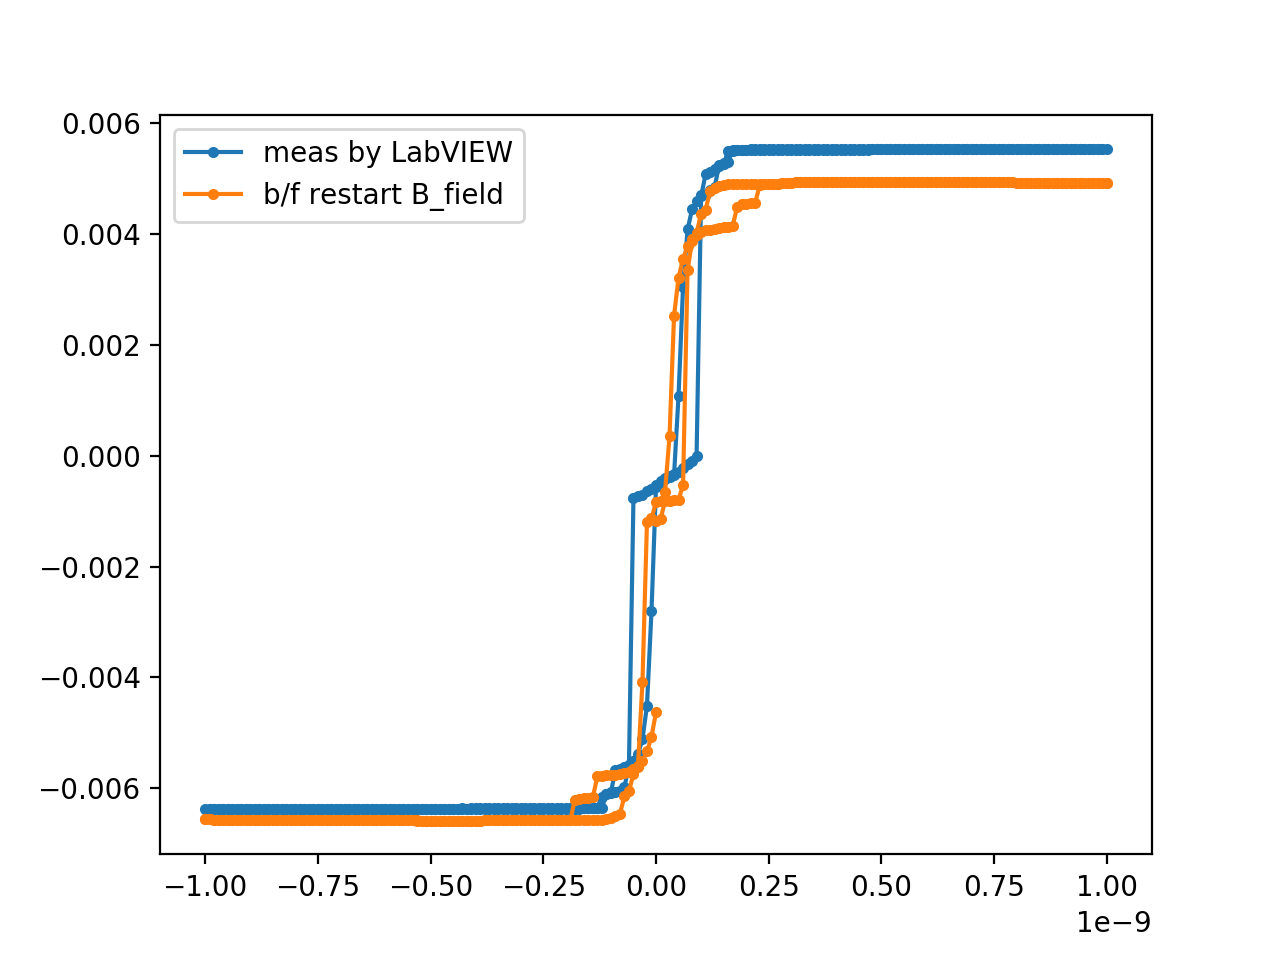

In [9]:
filepath1 = r'C:\Users\racco\Documents\QCoDes\measDC\experimental log toolbox'
filepath2 = r'C:\Users\racco\Documents\QCoDes\ExdData'

f,ax=plt.subplots()
dataLV = filetoDFM(filepath1 + r'\191104-70N3_IVc-115218.txt')
ax.plot(dataLV[0]['IS'],dataLV[0]['V1'], '.', ls='-',label = 'meas by LabVIEW')

qc.config["core"]["db_location"] = filepath2 + r'\Experiments_{}.db'.format('70B1N5')   
initialise_database()

label = ['b/f restart B_field']
for i,v in enumerate([1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    ax.plot(Is, Vs, '.', ls='-', label = '{}'.format(label[i]))

ax.legend()

#### Bar plots

<IPython.core.display.Javascript object>


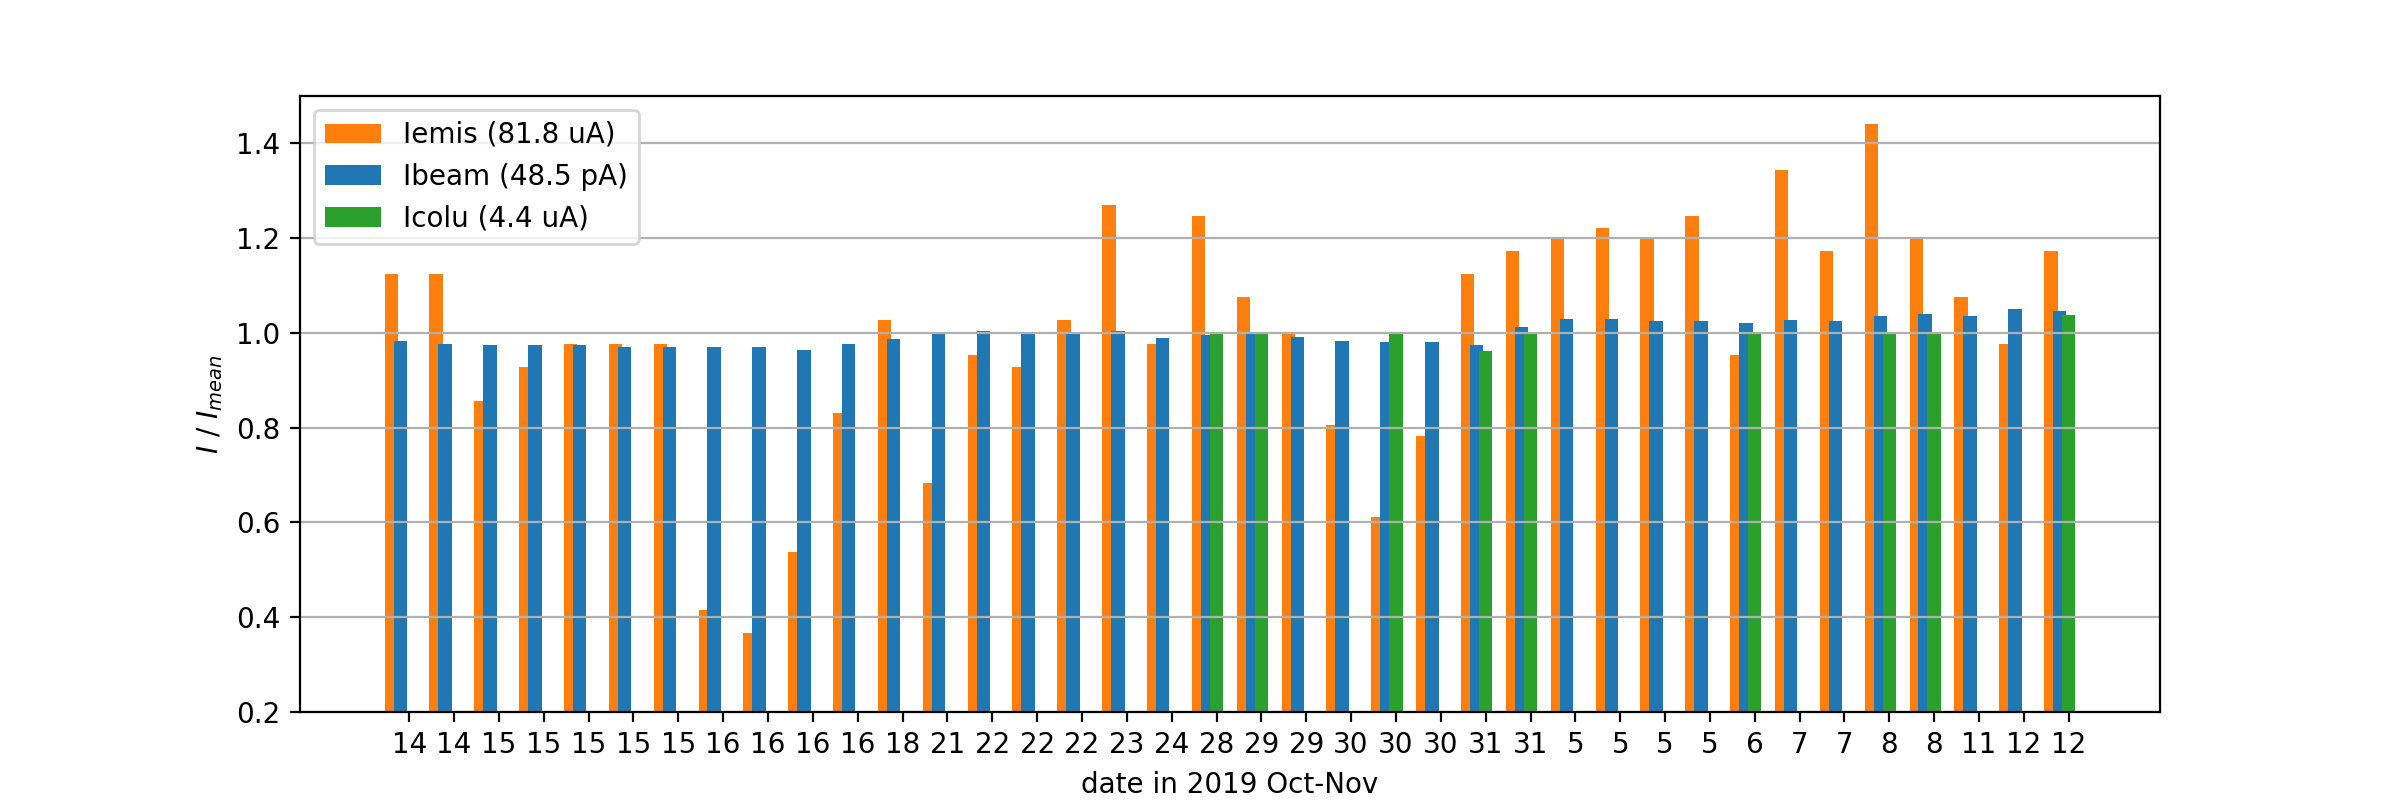

In [10]:
def lstmean (lst):
    for i,v in enumerate (lst):
        if v == 0:
            lst[i] = np.nan
    return np.nanmean(lst)

date = [ 14   , 14   , 15   , 15   , 15   , 15   , 15   , 16   , 16   , 16   , 16   , 18   , 21   , 22   , 22   , 22   , 23   , 24   , 28   , 29   , 29   , 30   , 30   , 30   , 31   , 31   , 5    , 5    , 5    , 5    , 6    , 7    , 7    , 8    , 8    , 11   , 12   , 12    ]
Iemi = [ 92   , 92   , 70   , 76   , 80   , 80   , 80   , 34   , 30   , 44   , 68   , 84   , 56   , 78   , 76   , 84   , 104  , 80   , 102  , 88   , 82   , 66   , 50   , 64   , 92   , 96   , 98   , 100  , 98   , 102  , 78   , 110  , 96   , 118  , 98   , 88   , 80   , 96    ]
Ibe1 = [ 47.6 , 47.3 , 47.2 , 47.2 , 47.2 , 47.0 , 47.0 , 47.0 , 47.0 , 46.7 , 47.3 , 47.8 , 48.4 , 48.7 , 48.5 , 48.5 , 48.7 , 47.9 , 48.2 , 48.5 , 48   , 47.6 , 47.5 , 47.5 , 47.2 , 49.1 , 49.9 , 49.9 , 49.7 , 49.7 , 49.5 , 49.8 , 49.7 , 50.2 , 50.4 , 50.2 , 50.9 , 50.7  ]
Icol = [ 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    ,  0   , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 0    , 4.354, 4.354, 0    , 0    , 4.354, 0    , 4.187, 4.354, 0    , 0    , 0    , 0    , 4.354, 0    , 0    , 4.354, 4.354, 0    , 0    , 4.522 ]
x = np.linspace(1,len(date),len(date))

Iemimean = lstmean(Iemi)
Ibe1mean = lstmean(Ibe1)
Icolmean = lstmean(Icol)

f,ax = plt.subplots (1,1,figsize=(12,4))
ax.bar(x    , Iemi/Iemimean, width=0.3, tick_label = date, 
       label = 'Iemis ({}uA)'.format(si_format(Iemimean)), color = 'C1')
ax.bar(x+0.2, Ibe1/Ibe1mean, width=0.3, tick_label = date, 
       label = 'Ibeam ({}pA)'.format(si_format(Ibe1mean)), color = 'C0')
ax.bar(x+0.4, Icol/Icolmean, width=0.3, tick_label = date, 
       label = 'Icolu ({}uA)'.format(si_format(Icolmean)), color = 'C2')
# plt.xlim(0,20)
ax.set_ylim(0.2,1.5)
ax.set_xlabel("date in 2019 Oct-Nov")
ax.set_ylabel("$I$ / $I_{mean}$")
ax.legend(loc=2)
ax.grid(True, 'both', axis = 'y')

#### Pie chart

<IPython.core.display.Javascript object>


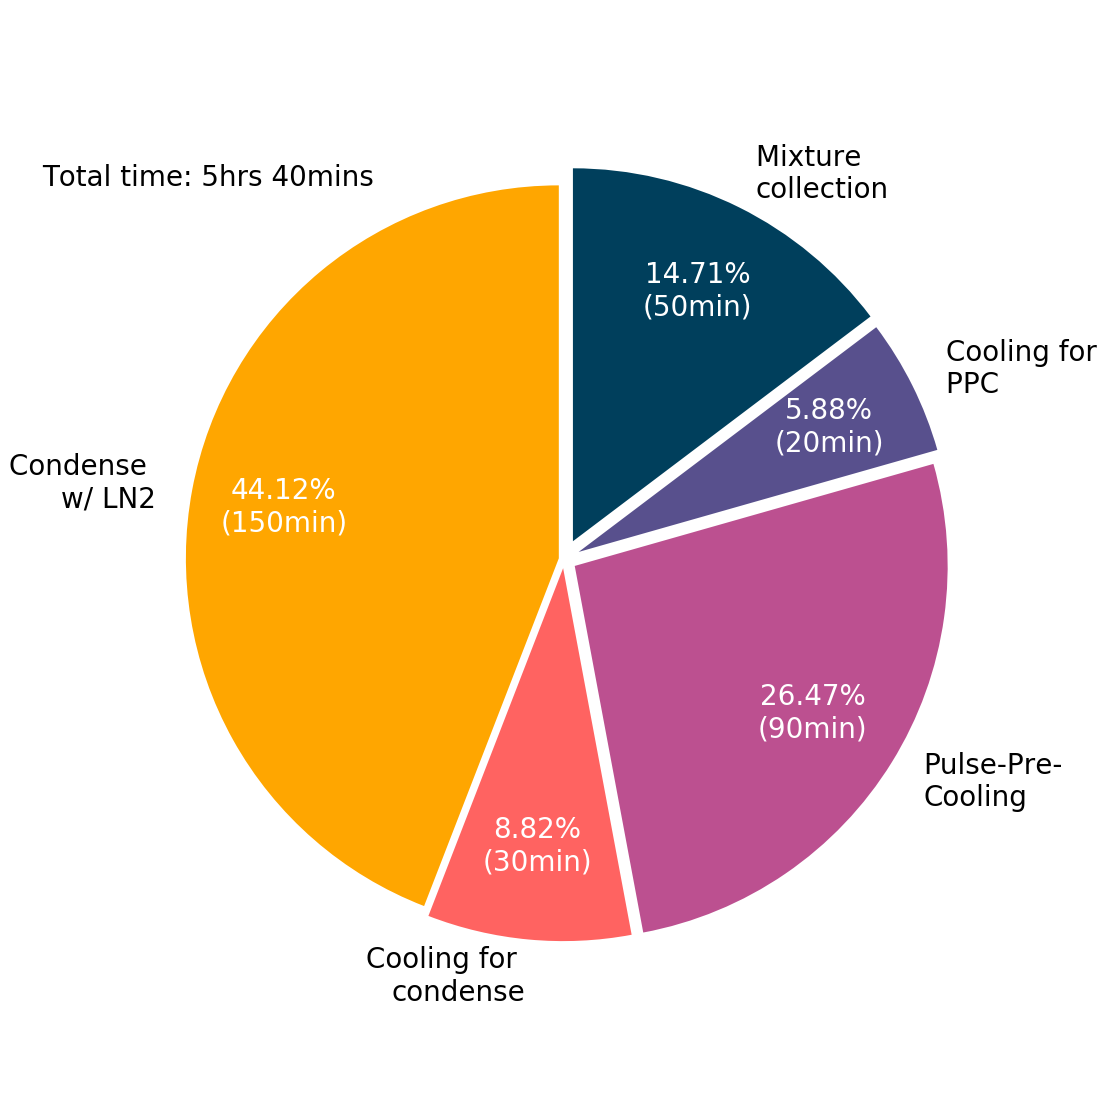

In [26]:
def min2hr(time='1hr20min'):
    hr, minu = time.split('hr')[0], time.split('hr')[1][:-3]
    return int(hr)*60+int(minu)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d}min)'.format(p=pct,v=val)
    return my_autopct


labels = ['Mixture \ncollection', 
          'Cooling for \nPPC ', 
          'Pulse-Pre-\nCooling',
          'Cooling for \ncondense',
          'Condense \nw/ LN2']

sizes =  [min2hr('0hr50min'), 
          min2hr('0hr20min'), 
          min2hr('1hr30min'), 
          min2hr('0hr30min'), 
          min2hr('2hr30min')]

colors = [[0    , 0.247, 0.361], 
          [0.345, 0.314, 0.553], 
          [0.737, 0.314, 0.565], 
          [1    , 0.388, 0.38 ],
          [1    , 0.651, 0    ],]

expldlst = np.array([])
for i in range(5):
    expldlst = np.append(expldlst, (1.35-i*0.25)/25)
explode = expldlst

_, _, autotexts = plt.pie(sizes, explode = explode, labels = labels, colors = colors, shadow = False,
                          autopct = make_autopct(sizes), startangle = 90, counterclock = False,
                          pctdistance=0.75, labeldistance=1.1)
for autotext in autotexts:
    autotext.set_color('white')

# '%1.1f%%'
plt.axis('equal')
plt.text(-1.4,1,'Total time: {}hrs {}mins'.format(int(np.floor(sum(sizes)/60)), 
                                                  np.remainder(sum(sizes),60)))
fig = plt.gcf()
fig.set_size_inches(5.5,5.5)
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)
plt.show()

### Pandas list and dictionary

#### Usage of merge

In [11]:
sku = [  122,  123,  113,  122,  123,  122,  301]
loc = [   61,   61,   62,   62,   62,   63,   63]
flag= [ True, True, True, True,False,False, True]
lst1= pd.DataFrame(data = list(zip(sku,loc,flag)), columns = ['sku', 'loc', 'flag'])
print(lst1,'\n')
sku = [  113,  122,  123,  301]
dep = [  'a',  'b',  'b',  'c']
lst2= pd.DataFrame(data = list(zip(sku,dep)), columns = ['sku', 'dep'])
print(lst2)

lst2.merge(lst1, on = 'sku', how = 'left')

   sku  loc   flag
0  122   61   True
1  123   61   True
2  113   62   True
3  122   62   True
4  123   62  False
5  122   63  False
6  301   63   True 

   sku dep
0  113   a
1  122   b
2  123   b
3  301   c


,sku,dep,loc,flag
0,113,a,62,True
1,122,b,61,True
2,122,b,62,True
3,122,b,63,False
4,123,b,61,True
5,123,b,62,False
6,301,c,63,True


#### <span class="mark">Q1D list</span>

In [35]:
key =    [ 'Device' ,    'T8',  'EJ/JJ',   'ECJ',  'ISW' ,     'R0ZF' ,     'R0FF' , '#ser', '#par' ]
unit=    ['       ' ,    'K' ,     'K' ,     'K',    'A' , '$\Omega$' , '$\Omega$' ,   'ea',   'ea' ]
lst =   [['D55BCN7' ,  0.030 ,   0.465 ,  0.214 ,      0 ,          0 ,          0 ,    20 ,      2 ],
         ['       ' ,  0.300 ,   0.465 ,  0.214 ,      0 ,          0 ,          0 ,    16 ,      2 ],
         ['D53N2  ' ,  0.030 ,   0.465 ,  8.131 ,      0 ,          0 ,          0 ,    20 ,      2 ],
         ['D55B1N9' ,  0.030 ,   0.465 ,  0.660 ,      0 ,          0 ,          0 ,    20 ,      2 ],
         ['D59B6N3' ,  0.030 ,   0.465 ,  0.905 ,      0 ,          0 ,          0 ,    20 ,      2 ],
         ['D59B0N1' ,  0.030 ,   0.465 ,  0.857 ,      0 ,          0 ,          0 ,     2 ,      2 ],
         ['D59BBN2' ,  0.030 ,   0.465 ,  0.044 ,      0 ,          0 ,          0 ,    20 ,      2 ],
         ['D62B3N2' ,  0.030 ,   0.465 ,  0.358 ,      0 ,          0 ,          0 ,    20 ,      2 ],
         ['D60B2N6' ,  0.030 ,   0.465 ,  0.408 ,      0 ,          0 ,          0 ,    20 ,      2 ],
         ['D60B2N2' ,  0.030 ,   0.465 ,  0.128 ,      0 ,          0 ,          0 ,     4 ,      2 ],
         ['D63BAN6' ,  0.030 ,   0.465 ,  0.238 ,      0 ,          0 ,          0 ,    30 ,      2 ],
         ['       ' , np.nan ,   0.465 ,  0.238 ,      0 ,          0 ,          0 ,    30 ,      2 ],
         ['D070   ' ,  0.030 ,   0.038 ,  0.763 ,      0 ,          0 ,          0 ,    16 ,      2 ]]
    
Q1Dlst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
Q1Duni =   dict(zip(key, unit))

<IPython.core.display.Javascript object>


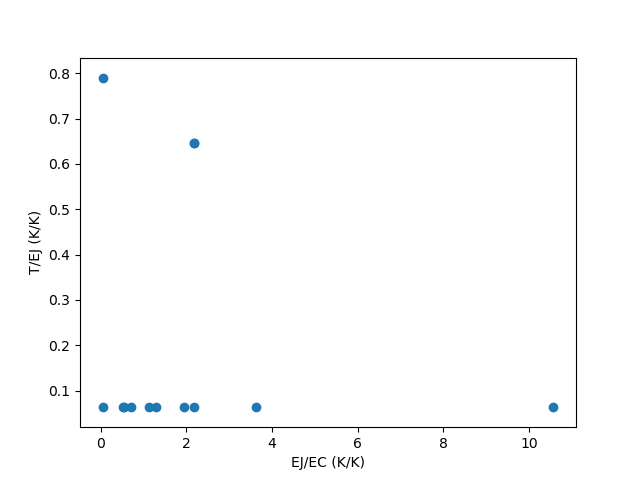

Text(0.5, 0, 'EJ/EC (K/K)')

In [37]:
ToEJlst  = np.array([])
EJoEClst = np.array([])

for devid in Q1Dlst.loc[:]['Device']:
    ToEJ  = Q1Dlst.loc[devid]['T8']/Q1Dlst.loc[devid]['EJ/JJ']
    ToEJlst = np.append(ToEJlst, ToEJ)
    EJoEC = Q1Dlst.loc[devid]['EJ/JJ']/Q1Dlst.loc[devid]['ECJ']
    EJoEClst= np.append(EJoEClst, EJoEC)

f,ax=plt.subplots()
ax.scatter(EJoEClst, ToEJlst)
ax.set_ylabel('T/EJ ({}/{})'.format(Q1Duni['T8'],Q1Duni['EJ/JJ']))
ax.set_xlabel('EJ/EC ({}/{})'.format(Q1Duni['EJ/JJ'],Q1Duni['ECJ']))

# for i, v in enumerate(devlst):
#     ax.annotate(v, (EJoEClst[i], ToEJlst[i]))

#### <span class="mark">Dome</span>

In [4]:
pd.set_option("display.precision", 3)

In [5]:
# Dome from literature
key =  [ '$T_C$', '$\\rho$']
# lst = [[    2.4  ,  100e-8 ],
#        [    3.0  ,  500e-8 ],
#        [    2.5  , 2000e-8 ],
#        [    2.7  ,  180e-8 ],
#        [    2.8  ,  350e-8 ],
#        [    2.2  , 3200e-8 ]]

lst = [[    1.3  ,   10e-8 ],
       [    2.4  ,  100e-8 ],
       [    2.6  ,  180e-8 ],
       [    2.9  ,  350e-8 ],
       [    3.0  ,  500e-8 ],
       [    3.1  ,  700e-8 ],
       [   3.08  , 1000e-8 ],
       [   2.93  , 1300e-8 ],
       [   2.60  , 2000e-8 ],
       [    2.2  , 3200e-8 ],
       [    1.2  ,12000e-8 ]]

domeLitDF =   pd.DataFrame(  data  = list(zip(*lst)), 
#                            columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                             index = key ).transpose()

# with open(r'dataframes/domeLitDF.csv','w') as f:
#     domeLitDF.to_csv(f)
# with open(r'dataframes/domeLitDF.csv','r') as f:
#     domeLitDF2 = pd.read_csv(f)
#     print(domeLitDF2)

In [5]:
# Dome for wet-grAl
key = ['Device'      ,    'THK','$w_{re}$','$l_{re}$',     '$R$', '$T_C$', '$I_C$',   'dose', '$l_i$', 'tilt','$R_{af}$','$R_{1w}$','$T_{C,1w}$']
unit= [''            ,      'm',       'm',       'm','$\Omega$',     'K',     'A', '#/cm^2',     'm',  'deg','$\Omega$','$\Omega$',         'K']
lst =[
# old device
      ['ALOX06'       ,  150e-9,     5e-6 ,  52.7e-6 ,    13490 ,   1.39 ,5.65e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX05B_10um' ,   35e-9,  9.97e-6 ,  35.4e-6 ,     4260 ,    1.7 ,0.41e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX05B_2um'  ,   28e-9,  1.94e-6 ,    17e-6 ,    13140 ,    1.7 , 3.3e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX05B_.5um' ,   20e-9,   0.8e-6 ,    17e-6 ,   105190 ,   1.75 ,12.5e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX03'       ,  140e-9,   5.0e-6 ,    18e-6 ,     3120 ,    1.2 , 4.6e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['ALOX07_10um'  ,   40e-9,    10e-6 ,    18e-6 ,     1390 ,   1.73 ,14.5e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['Q1D066B8'     ,   40e-9,   0.7e-6 ,    18e-6 ,    29250 ,   1.80 ,12.5e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
      ['Q1D067B8'     ,   40e-9,   0.7e-6 ,    18e-6 ,    24560 ,   2.00 ,12.5e-6 ,  np.nan , np.nan ,np.nan ,  np.nan ,   np.nan ,     np.nan ],
# HIM grAl device
      ['D335bN8_Up'   ,   40e-9,  0.65e-6 ,    16e-6 ,     5700 ,   2.03 , np.nan ,    1e12 ,  13e-6 ,     0 ,     7330 ,     3300 ,       1.97 ],
      ['D335bN8_Mid'  ,   40e-9,  0.65e-6 ,    16e-6 ,     5800 ,   1.95 , np.nan ,    1e16 ,  13e-6 ,     0 ,    417.0 ,     4700 ,       1.98 ],
      ['D335bN8_Dow'  ,   40e-9,  0.65e-6 ,    16e-6 ,     5600 ,   1.85 , np.nan ,    5e16 ,  13e-6 ,     0 ,     4890 ,     5900 ,       1.97 ],
      ['D276bN8_Up'   ,   40e-9,  0.65e-6 ,    16e-6 ,     3507 , np.nan , np.nan ,    1e12 ,  13e-6 ,     0 ,     3970 ,     3120 ,     np.nan ],
      ['D276bN8_Mid'  ,   40e-9,  0.65e-6 ,    16e-6 ,     3500 ,   2.02 , np.nan ,    1e16 ,  13e-6 ,     0 ,    447.0 ,     2740 ,     np.nan ],
      ['D276bN8_Dow'  ,   40e-9,  0.65e-6 ,    16e-6 ,     3400 ,   1.95 , np.nan ,    5e16 ,  13e-6 ,     0 ,     2850 ,     1980 ,     np.nan ],
      ['D06N5_Mid'    ,   55e-9,  7.05e-6 ,  11.8e-6 ,     1400 ,   1.87 , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['D06N7_Mid'    ,   23e-9,  0.47e-6 ,  16.4e-6 ,    78900 ,   1.78 , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
# HIM pure Al device
      ['SiOx002N1_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N2_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N3_Mid',   40e-9,  1.51e-6 ,  17.9e-6 ,     52.8 , np.nan , np.nan ,    5e17 ,  13e-6 ,     0 ,   63.32  ,   np.nan ,     np.nan ],
      ['SiOx002N4_Mid',   48e-9,  3.06e-6 ,  12.2e-6 ,     18.0 , np.nan , np.nan ,    1e17 ,   8e-6 ,     0 ,    18.6  ,   np.nan ,     np.nan ],
      ['SiOx002N5_Mid',   55e-9,  7.05e-6 ,  11.8e-6 ,     5.78 , np.nan , np.nan ,    1e18 , 8.2e-6 ,    35 ,   8.713  ,   np.nan ,     np.nan ],
      ['SiOx002N6_Mid',  np.nan,  12.3e-6 ,  11.9e-6 ,     2.86 , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N7_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N8_Mid',   44e-9,  1.48e-6 ,  15.9e-6 ,    53.70 , np.nan , np.nan ,    5e16 ,   8e-6 ,     0 ,    47.9  ,   np.nan ,     np.nan ],
      ['SiOx002N9_Mid',  np.nan,  12.4e-6 ,  12.0e-6 ,     2.88 , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx002N0_Mid',   44e-9,  0.99e-6 ,  16.0e-6 ,     72.0 , np.nan , np.nan ,    1e18 ,  13e-6 ,     0 ,   177.6  ,   np.nan ,     np.nan ],  

      ['SiOx003N1_Mid', 17.8e-9,  0.37e-6 ,  16.3e-6 ,     1750 , np.nan , np.nan ,    1e18 ,10.7e-6 ,    35 ,     1775 ,   np.nan ,     np.nan ],
      ['SiOx003N2_Mid',  np.nan,   np.nan ,   np.nan ,   np.nan , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N3_Mid',   40e-9,  1.51e-6 ,  15.8e-6 ,    54.50 , np.nan , np.nan ,    5e18 ,  13e-6 ,     0 ,    121.8 ,   np.nan ,     np.nan ],
      ['SiOx003N4_Mid',   48e-9,  2.95e-6 ,  12.3e-6 ,     18.0 ,   1.42 , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N5_Mid',   55e-9,  7.05e-6 ,  11.8e-6 ,     5.77 , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N6_Mid',   56e-9,  12.3e-6 ,  12.3e-6 ,     2.90 ,   1.43 , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N7_Mid',   23e-9,  0.47e-6 ,  16.4e-6 ,     1050 , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N8_Mid',   44e-9,  1.48e-6 ,  15.9e-6 ,     53.7 , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N9_Mid', 52.6e-9,  12.1e-6 ,  11.9e-6 ,     2.91 , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['SiOx003N0_Mid',  np.nan,   np.nan ,   np.nan ,      159 , np.nan , np.nan ,  np.nan , np.nan ,np.nan ,   np.nan ,   np.nan ,     np.nan ]]

domeWetun =   dict(zip(key, unit))
domeWetDF =   pd.DataFrame(    data  = list(zip(*lst)), 
#                             columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                               index = domeWetun ).transpose()

# with open(r'dataframes/domeWetDF.csv','w') as f:
#     domeWetDF.to_csv(f)
# with open(r'dataframes/domeWetDF.csv','r') as f:
#     domeWetDF = pd.read_csv(f)
#     print(domeWetDF)

#domeWetDF[domeWetDF['Device'] == 'SiOx003N3_Mid']['$R$'].tolist()[0]

In [42]:
# Dome for dry-grAl
key = ['Device'       , 'THK','$w_{re}$','$l_{re}$',     '$R$', '$T_C$', '$I_C$',   'dose','$R_{af}$','$R_{co}$','$T_{C,af}$']
unit= [''             ,   'm',       'm',       'm','$\Omega$',     'K',     'A', '#/cm^2','$\Omega$','$\Omega$',         'K']
lst =[         
      ['D06N5_Mid'    , 55e-9,  7.05e-6 ,  11.8e-6 ,     1400 ,   1.87 , np.nan ,  np.nan ,   np.nan ,   np.nan ,     np.nan ],
      ['D06N7_Mid'    , 23e-9,  0.47e-6 ,  16.4e-6 ,    78900 , np.nan , np.nan ,  np.nan ,   np.nan ,   np.nan ,     np.nan ]
     ]

domeDryun =   dict(zip(key, unit))
domeDryDF =   pd.DataFrame(    data  = list(zip(*lst)), 
                             columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                               index = domeDryun ).transpose()

# with open(r'dataframes/domeDryDF.csv','w') as f:
#     domeDryDF.to_csv(f)
# with open(r'dataframes/domeDryDF.csv','r') as f:
#     domeDryDF = pd.read_csv(f)
#     print(domeDryDF)

<IPython.core.display.Javascript object>


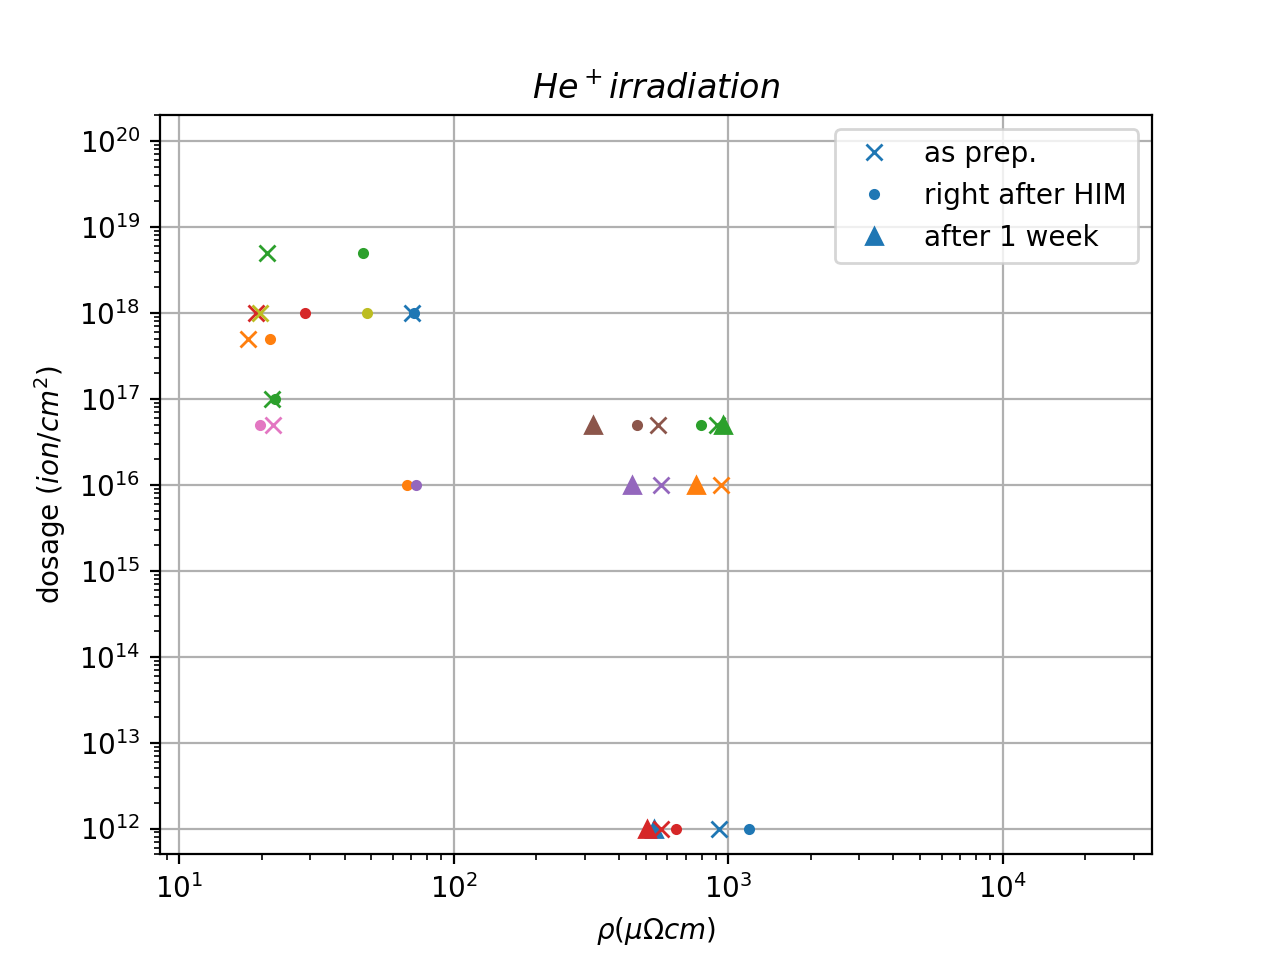

In [45]:
rho    = domeWetDF['$R$']     /domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_af = domeWetDF['$R_{af}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_1w = domeWetDF['$R_{1w}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']

plt.close('all')
f,ax=plt.subplots()
label = [['as prep.','right after HIM','after 1 week']]
for i,v in enumerate(range(8,len(domeWetDF))):#
    label.append([None,None,None])
    ax.plot(rho[v   ]*1e8,domeWetDF['dose'][v], 'x', label = label[i][0], color='C{}'.format(int(i%9)))
    ax.plot(rho_af[v]*1e8,domeWetDF['dose'][v], '.', label = label[i][1], color='C{}'.format(int(i%9)))
    ax.plot(rho_1w[v]*1e8,domeWetDF['dose'][v], '^', label = label[i][2], color='C{}'.format(int(i%9)))

ax.set_xlim(8.5e-8*1e8,3.5e-4*1e8)
ax.set_ylim(5e11,2e20)
ax.set_xlabel('$\\rho (\mu\Omega cm)$')
ax.set_ylabel('dosage ($ion/cm^2)$')
ax.set_title('$He^+ irradiation$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True)
# ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
# plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


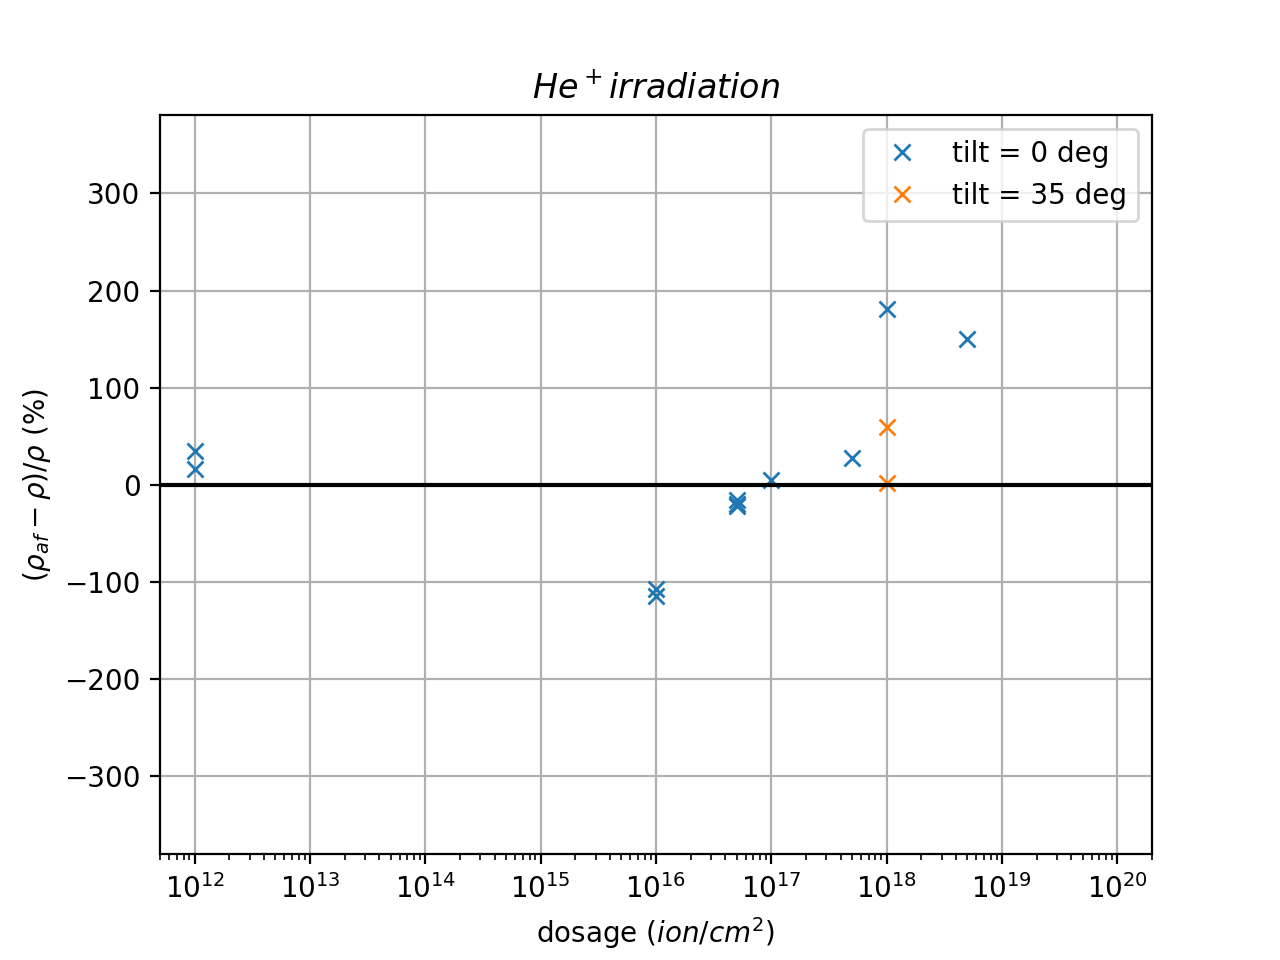

In [17]:
rho    = domeWetDF['$R$']     /domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_af = domeWetDF['$R_{af}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_1w = domeWetDF['$R_{1w}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']

drho = (rho_af - rho)/rho * domeWetDF['$l_{re}$']/(domeWetDF['$l_i$'] / np.cos(np.radians(domeWetDF['tilt'].tolist())))

plt.close('all')
f,ax=plt.subplots()

ax.plot(domeWetDF[domeWetDF[:]['tilt'] == 0]['dose'].tolist(),
        drho[domeWetDF[domeWetDF[:]['tilt'] == 0].index.tolist()]*100,
        'x', label = 'tilt = 0 deg')

ax.plot(domeWetDF[domeWetDF[:]['tilt'] == 35]['dose'].tolist(),
        drho[domeWetDF[domeWetDF[:]['tilt'] == 35].index.tolist()]*100,
        'x', label = 'tilt = 35 deg')

ax.axhline(color = 'black')

ax.set_ylim(-100*float(drho.max())-200,100*float(drho.max())+200)
ax.set_xlim(5e11,2e20)
ax.set_ylabel('$(\\rho_{af} - \\rho)/\\rho$ $(\%)$')
ax.set_xlabel('dosage ($ion/cm^2)$')
ax.set_title('$He^+ irradiation$')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
plt.show()

<IPython.core.display.Javascript object>


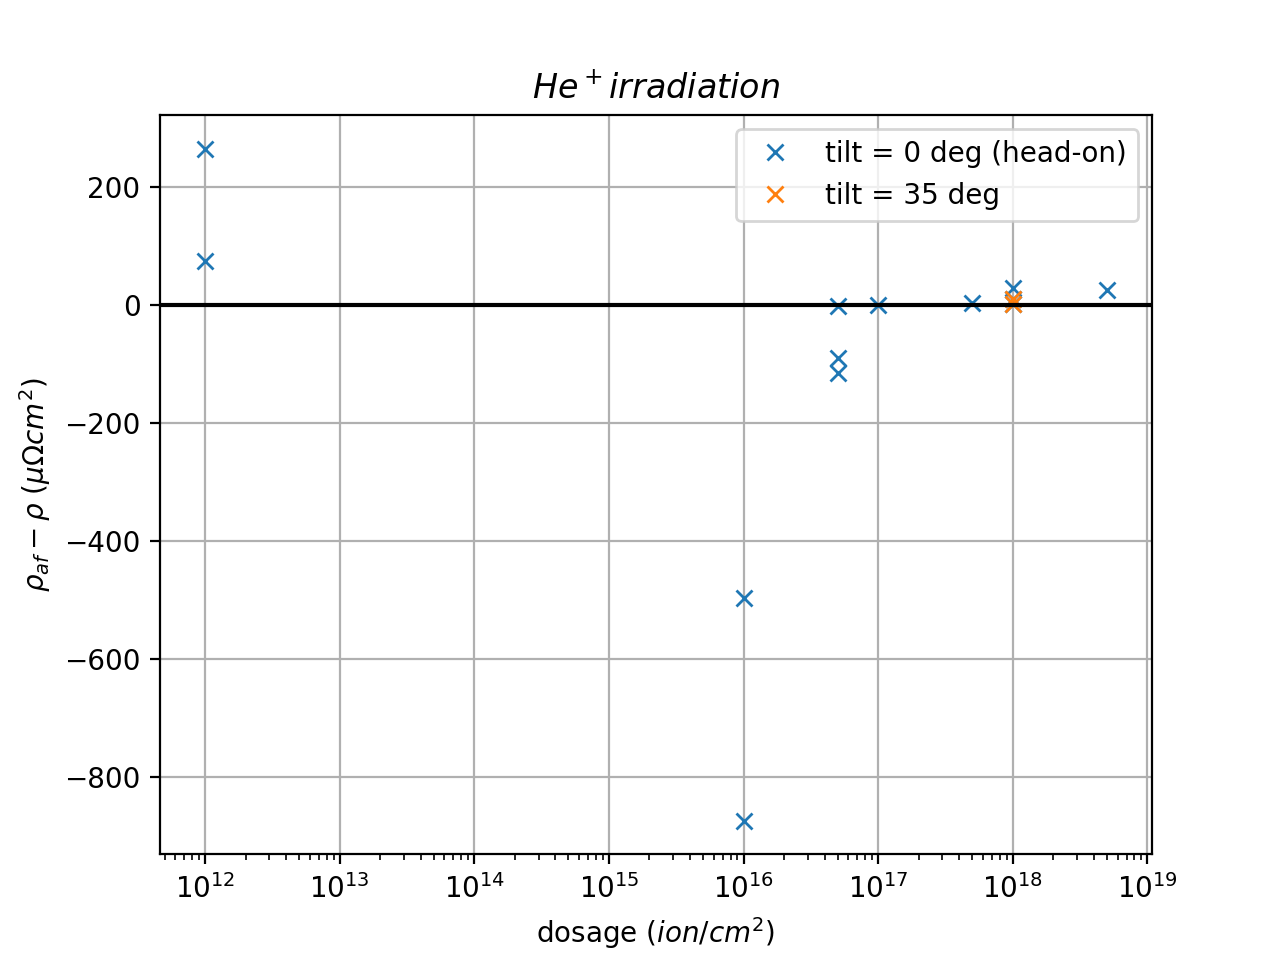

In [79]:
rho    = domeWetDF['$R$']     /domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_af = domeWetDF['$R_{af}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_1w = domeWetDF['$R_{1w}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']

drho = (rho_af - rho)*1e8# * domeWetDF['$l_{re}$']/domeWetDF['$l_i$']

plt.close('all')
f,ax=plt.subplots()
ax.plot(domeWetDF['dose'],drho, 'x', label = 'tilt = 0 deg (head-on)')
ax.plot(domeWetDF['dose'][20],drho[20], 'x', label = 'tilt = 35 deg')
ax.plot(domeWetDF['dose'][26],drho[26], 'x', color = 'C1')
ax.axhline(color = 'black')

# ax.set_ylim(-100*float(drho.max())-200,100*float(drho.max())+200)
# ax.set_xlim(5e11,2e20)
ax.set_ylabel('$\\rho_{af} - \\rho$ $(\mu\Omega cm^2)$')
ax.set_xlabel('dosage ($ion/cm^2)$')
ax.set_title('$He^+ irradiation$')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
plt.show()

<IPython.core.display.Javascript object>


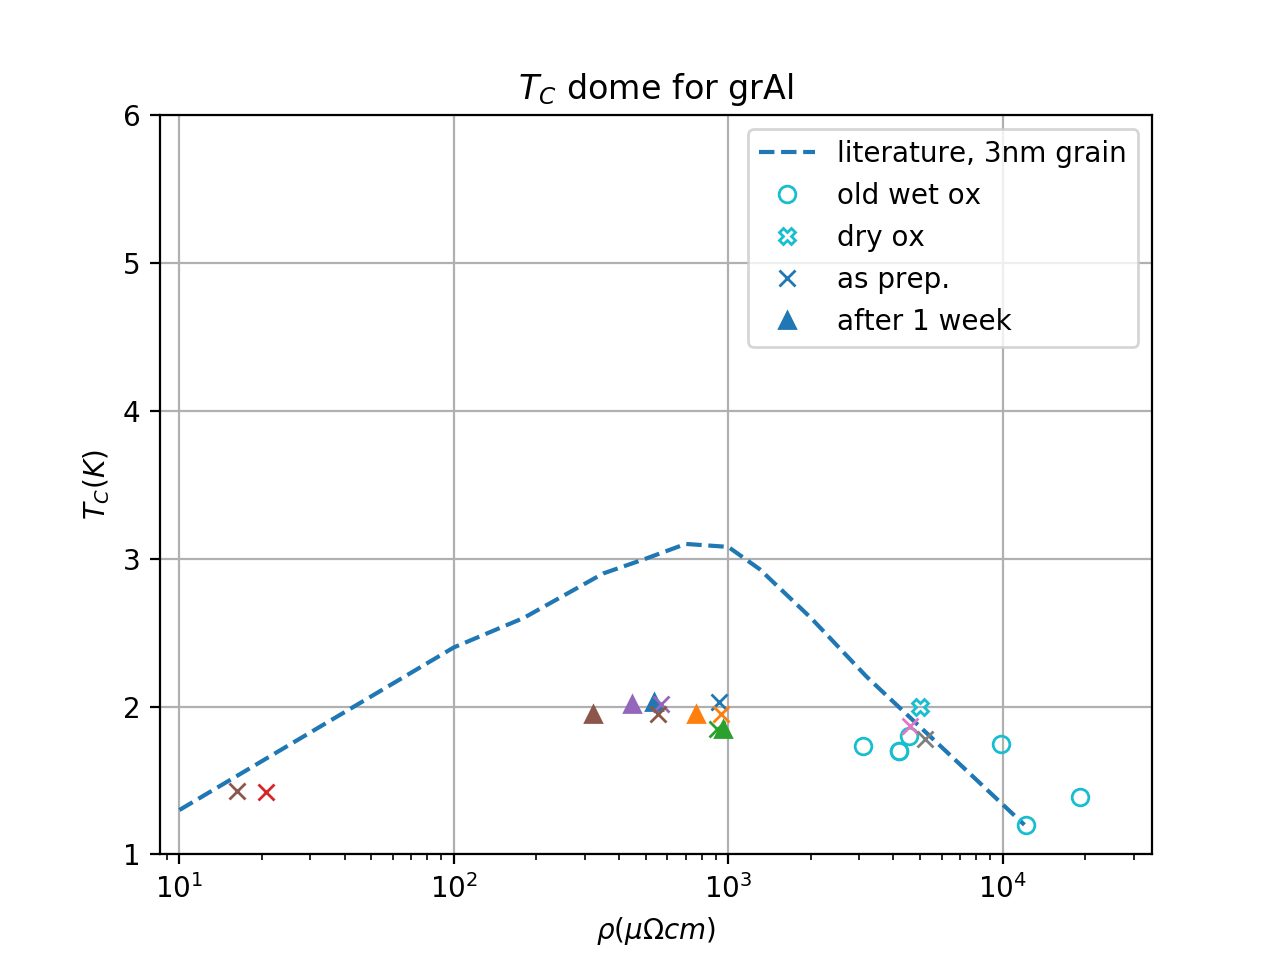

In [31]:
rho    = domeWetDF['$R$']     /domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_af = domeWetDF['$R_{af}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']
rho_1w = domeWetDF['$R_{1w}$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$']

plt.close('all')
f,ax=plt.subplots()
ax.plot(domeLitDF['$\\rho$']*1e8, domeLitDF['$T_C$'], '--', label = 'literature, 3nm grain')
ax.plot(rho[ 0: 7]*1e8, domeWetDF['$T_C$'][ 0: 7], 'o', fillstyle='none', label = 'old wet ox', color = 'C9')

ax.plot(5000, 2, 'X', fillstyle='none', label = 'dry ox', color = 'C9')

label = [['as prep.','after 1 week']]
for i,v in enumerate(range(8,len(domeWetDF))):#
    label.append([None,None])
    ax.plot(rho[v   ]*1e8,domeWetDF['$T_C$'][v], 'x', label = label[i][0], color='C{}'.format(int(i%9)))
    ax.plot(rho_1w[v]*1e8,domeWetDF['$T_C$'][v], '^', label = label[i][1], color='C{}'.format(int(i%9)))

# label = [['as prep.','af HIM/1 wk']]
# for i in range(8,23+1):
#     label.append([None,None])
#     ax.plot(rho[i]   *1e8, domeWetDF['$T_C$'][i]     , 'x', label = label[i-8][0], color = 'C{}'.format(int(i%9)))
#     ax.plot(rho_af[v]*1e8,domeWetDF['dose'][v], '.', label = label[i][1], color='C{}'.format(int(i%9)))    ax.plot(rho_1w[i]*1e8, domeWetDF['$T_{C,1w}$'][i], '^', label = label[i-8][1], color = 'C{}'.format(int(i%9)))

ax.set_xlim(8.5e-8*1e8,3.5e-4*1e8)
ax.set_ylim(1,6)
ax.set_xlabel('$\\rho (\mu\Omega cm)$')
ax.set_ylabel('$T_C (K)$')
ax.set_title('$T_C$ dome for grAl')
ax.set_xscale('log')
ax.legend()
ax.grid(True)
# ax.ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))
plt.show()

#### <span class="mark">pure Al thin film quality</span>
"resistivity mean free path electron phonon aluminum"

<IPython.core.display.Javascript object>


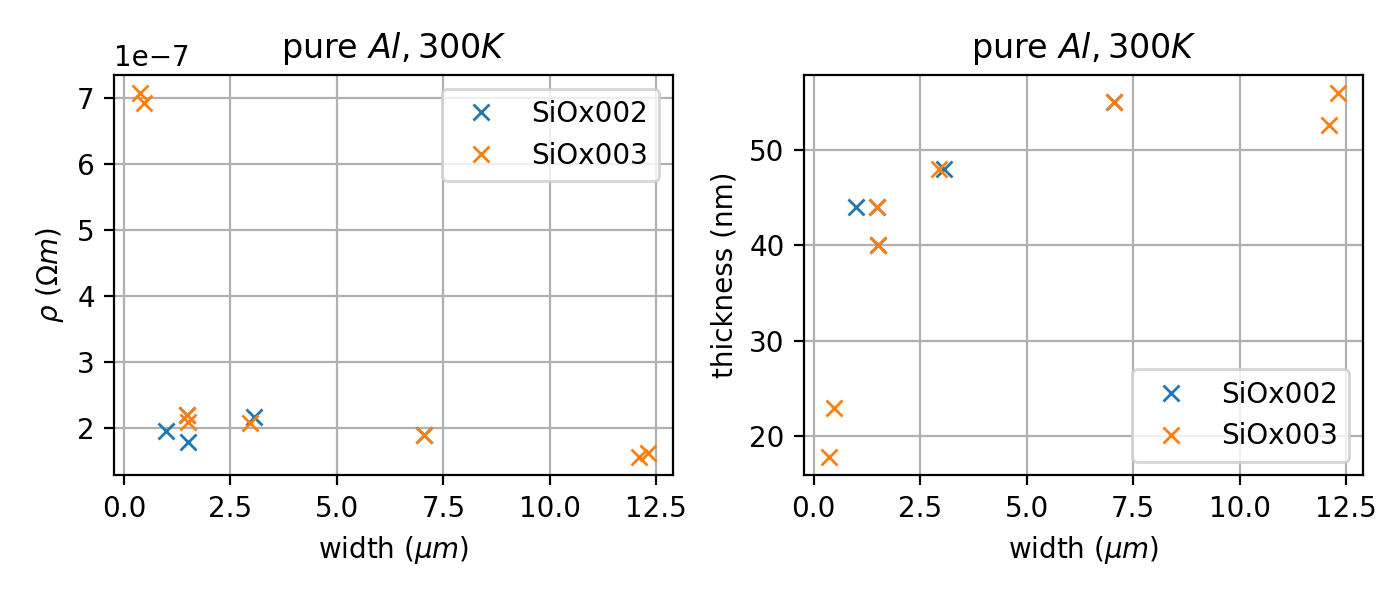

In [65]:
rho    = domeWetDF[16:]['$R$']     /domeWetDF[16:]['$l_{re}$']*domeWetDF[16:]['THK']*domeWetDF[16:]['$w_{re}$']
rho_1w = domeWetDF[16:]['$R_{1w}$']/domeWetDF[16:]['$l_{re}$']*domeWetDF[16:]['THK']*domeWetDF[16:]['$w_{re}$']
rho_af = domeWetDF[16:]['$R_{af}$']/domeWetDF[16:]['$l_{re}$']*domeWetDF[16:]['THK']*domeWetDF[16:]['$w_{re}$']

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

ax[0].plot(domeWetDF[16:26]['$w_{re}$']*1e6, rho[:10], 'x', label = 'SiOx002')
ax[0].plot(domeWetDF[26:36]['$w_{re}$']*1e6, rho[10:], 'x', label = 'SiOx003')
ax[0].ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))

ax[0].legend()
ax[0].set_xlabel('width ($\mu m$)')
ax[0].set_ylabel('$\\rho$ $(\Omega m)$')
ax[0].set_title('pure $Al, 300K$')
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

ax[1].plot(domeWetDF[16:26]['$w_{re}$']*1e6, domeWetDF[16:26]['THK']*1e9, 'x', label = 'SiOx002')
ax[1].plot(domeWetDF[26:36]['$w_{re}$']*1e6, domeWetDF[26:36]['THK']*1e9, 'x', label = 'SiOx003')
ax[1].ticklabel_format(axis = 'both', style = 'sci', scilimits=(0,2))

ax[1].legend()
ax[1].set_xlabel('width ($\mu m$)')
ax[1].set_ylabel('thickness (nm)')
ax[1].set_title('pure $Al, 300K$')
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()
plt.show()

## Real products

### Fridge handling log

In [ ]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

# T8.get()

## Update RTc for T8>102K

Locate files "CH8 T dd-mm-yy.log" and "CH0 T dd-mm-yy.log" under below path:

C:\Users\KelvinOX25\Documents\GitHub\measDC

Copy them to below path:

\\SERIN135_DR-PC\BlueFors\Temperature Log\dd-mm-yy

Then run below two cells

In [272]:
import time, datetime

def getTt(rootpath, filedate = '21-11-19', Tch = 0):
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
    filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
            vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
            vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if vt2 == vt1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

<IPython.core.display.Javascript object>


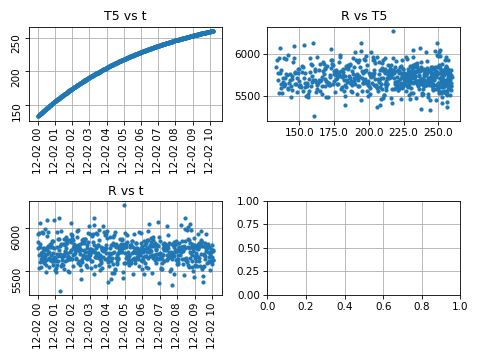

In [281]:
rootpath = r'\\SERIN135_DR-PC\BlueFors\Temperature Log'
filedate = '02-12-19'
Tch = 5
dhrslst1, dlst1, Tlst1 = getTt(rootpath=rootpath, filedate = filedate, Tch = Tch)
dhrslstR, dlstR, TlstR = getTt(rootpath=rootpath, filedate = filedate, Tch = 0)

TlstRnew = fillDataGap(ref_x1 = dlst1, gapped_x2 = dlstR, gapped_y2 = TlstR)
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(dlst1,Tlst1,'.')
ax[0][0].set_title('T{} vs t'.format(Tch))
ax[0][0].tick_params(labelrotation=90)

ax[1][0].plot(dlstR,TlstR,'.')
ax[1][0].set_title('R vs t')
ax[1][0].tick_params(labelrotation=90)

ax[0][1].plot(Tlst1,TlstRnew,'.')
from matplotlib.ticker import FormatStrFormatter
ax[0][1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0][1].set_title('R vs T{}'.format(Tch))


for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()

plt.tight_layout()
plt.show()

### Search I_SW segments

NameError: name 'filetoDFM' is not defined

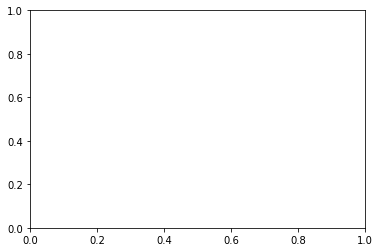

In [11]:
filepath = r'C:\Users\racco\Documents\2experimental log toolbox'

f,ax=plt.subplots()
dataLV = filetoDFM(filepath + r'\191104-70N3_IVc-115218.txt')
ax.plot(dataLV[0]['IS'],dataLV[0]['V1'], '.', ls='-',label = 'meas by LabVIEW')
ax.show()

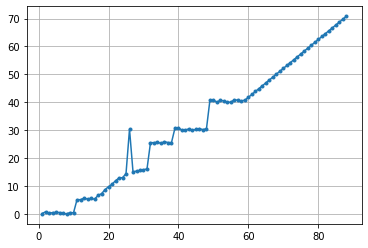

In [9]:
s = 10
lst = np.asarray([])
lsts = [np.random.rand(1,  s)                                 ,
        np.random.rand(1,  5) + 5                             ,
        np.random.rand(1,  s) + 5 + 1*np.linspace(0,s-1,s)    ,
        np.random.rand(1,  1) + s + s*2                       ,
        np.random.rand(1,  1) + s + 5 + 1*np.linspace(0, 1 ,5),
        np.random.rand(1,  7) + s + s*1.5                     ,
        np.random.rand(1, 10) + s + s*2                       ,
        np.random.rand(1, 10) + s + s*3                       ,
        np.random.rand(1,  1) + s*4   +30*np.linspace(0, 1 ,30) ]

for l in lsts:
    lst = np.append(lst, 1*l)

plt.plot(np.linspace(1,len(lst),len(lst)),lst,'.-')
plt.grid(True)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataLV[0]['IS']
dataLV[0]['V1']
lstx = dataLV[0]['IS'].values.tolist()
lst = dataLV[0]['V1'].values.tolist()
datarngs = 0
datarnge = int(np.floor(1*len(lst)/4))
datarngs = int(np.floor(2*len(lst)/4))
datarnge = int(np.floor(3*len(lst)/4))
lstx = lstx[datarngs:datarnge]
lst = lst[datarngs:datarnge]


NameError: name 'lstx' is not defined

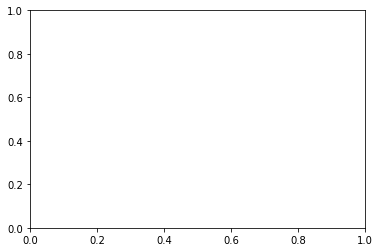

In [13]:
y_thr = 5.5e-3
y_jmp = 0.4e-3

lstd = np.flip(np.append(np.flip(np.diff(lst),0), lst[0]),0)
ids = np.array([])

for i,v in enumerate(lstd):
    if i <= len(lstd)-1 :
        if ((np.abs(v) >= y_jmp) and (np.abs(lstd[i+1]) <= y_jmp)) or (lst[i] >= y_thr):
            ids = np.append(ids, i)
            if lst[i] >= y_thr:
                break

ids = ids.astype(int)
lstNew = np.asarray([])

plt.close('all')
f,ax = plt.subplots()
ax.plot(lstx,lst,'-')
ax.grid(True)

ids = np.flip(np.append(np.flip(ids,0), 0),0)
for i,v in enumerate(ids):
    if i <= len(ids)-2:
        x = lstx[v:ids[i+1]]
        y =  lst[v:ids[i+1]]
        ax.plot(x,y,'.')

plt.show()

### Copy image and show inline

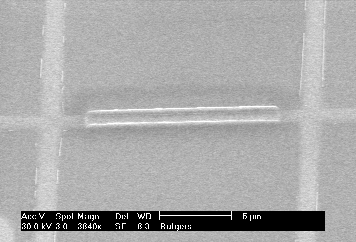

In [69]:
#This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

import time, os
dir_path = os.getcwd()
pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,
                                                     time.localtime()[1],
                                                     time.localtime()[2],
                                                     time.localtime()[3],
                                                     time.localtime()[4],
                                                     time.localtime()[5])

from PIL import ImageGrab
img = ImageGrab.grabclipboard()
img.save(pngpath, 'PNG')

resize = 2
from PIL import Image
try: 
    img = Image.open(pngpath) 
    width, height = img.size 
    img = img.resize((int(width/resize), int(height/resize))) 
    img.save(pngpath) 
except IOError: 
    pass

from IPython.display import Image, display
display(Image(filename=pngpath))

import clipboard
clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))
# display(Image(filename=r'C:\Users\racco\Documents\2experimental log toolbox\img\19113-124212.png'))

### Strip data strings from dry fridge logs

In [ ]:
import time, datetime

def getTt(filepath, Tch = 0):
    filedate = '21-11-19'
    filename = r'\\'+filedate+'\CH{} T '.format(Tch)+filedate+'.log'
#     filepath = rootpath+filename

    dateori = datetime.datetime(2019,11,21,0,0,0)
    dhrslst = []
    dlst = []
    Tlst = []
    with open(filepath) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            l = line.strip()
            d = datetime.datetime(int(l.split(',')[0].split('-')[2])+2000,
                                  int(l.split(',')[0].split('-')[1]),
                                  int(l.split(',')[0].split('-')[0]),
                                  int(l.split(',')[1].split(':')[0]),
                                  int(l.split(',')[1].split(':')[1]),
                                  int(l.split(',')[1].split(':')[2]))
            T = float(l.split(',')[2])
            dhrslst.append(((d-dateori).days *86400 + (d-dateori).seconds)/60/60)
            dlst.append(d)
            Tlst.append(T)
            line = fp.readline()
            cnt += 1
    fp.close()
    return (dhrslst, dlst, Tlst)

### Align data with gaps

In [4]:
def fillDataGap(ref_x1, gapped_x2, gapped_y2):
    filled_y2 = np.full_like(np.arange(len(ref_x1)),np.nan, dtype=np.double)
    for i,v2 in enumerate(gapped_x2):
        for j,v1 in enumerate(ref_x1):
#             vt1 = v1.year*525600 + v1.month*43800 + v1.day*1440 + v1.hour*60 + v1.minute
#             vt2 = v2.year*525600 + v2.month*43800 + v2.day*1440 + v2.hour*60 + v2.minute
            if v2 == v1:
                filled_y2[j]= gapped_y2[i]
                break
    return filled_y2

In [13]:
#x1 = np.linspace(1,20,20)
# y = x1+1

# x2 = np.append(np.linspace(1,10,10),(np.linspace(16,20,5)))
# z = 2*x2+1

x1 = np.linspace(1,200,200)
y1 = np.sin(x1/len(x1)*np.pi*2)

x2 = np.append(np.linspace(1,100,100),(np.linspace(151,200,50)))
y2 = np.cos(x2/len(x1)*np.pi*2)

y2new = fillDataGap(ref_x1 = x1, gapped_x2 = x2, gapped_y2 = y2)

<IPython.core.display.Javascript object>


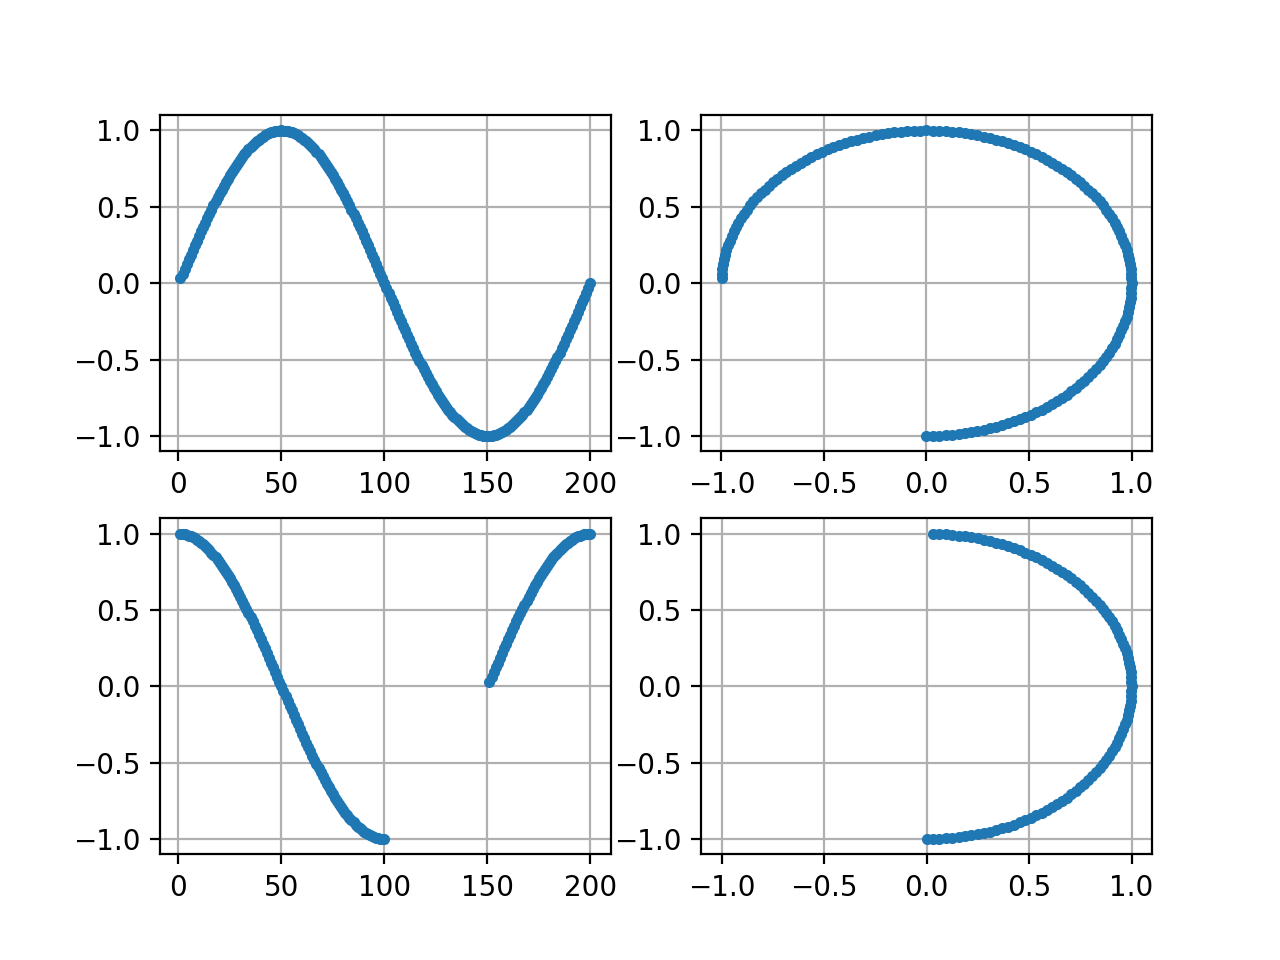

In [14]:
plt.close('all')
f,ax = plt.subplots(2,2)
ax[0][0].plot(x1,y1,'.')
ax[1][0].plot(x2,y2,'.')
ax[0][1].plot(y1,y2new,'.')
ax[1][1].plot(y1[0:100],y2[0:100],'.')

ax[1][1].set_xlim(-1.1,1.1)
ax[1][1].set_ylim(-1.1,1.1)
for i in [0,1]:
    for j in [0,1]:
        ax[i][j].grid()     
plt.show()

### Handle exception

In [144]:
for i in (domeWetDF['$R$']/domeWetDF['$l_{re}$']*domeWetDF['THK']*domeWetDF['$w_{re}$'])[10:15]:
    try:
        print(si_format(i,4))
    except (ValueError,IOError) as err:
        print(err)

9.1000 µ
cannot convert float NaN to integer
5.6875 µ
5.5250 µ
111.7246 µ


### Log ids, data centering etc

In [3]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

pd.set_option("display.precision", 3)

In [29]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[              [8,9,10],  43e-3, np.array([ZF,midF,FF])              ,   4e-3, 'quick IVc meas'  ],  
       [                  [13],  43e-3, np.array([ZF,midF,FF])              ,  4e-3, ''                ],  
       [range(  22,   42+1)[:],  50e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  43,   63+1)[:], 100e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  64,   84+1)[:], 150e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range(  85,  105+1)[:], 200e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 106,  126+1)[:], 250e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 127,  147+1)[:], 300e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 148,  168+1)[:], 350e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 169,  189+1)[:], 400e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 190,  210+1)[:], 450e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 211,  231+1)[:], 500e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 232,  252+1)[:], 550e-3, np.linspace(ZF, ZF + 1.0*dF, 21)    ,   4e-3, ''                ],  
       [range( 253,  262+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc_ada'],  
#        [range( 263,  272+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],  
       [range( 273,  282+1)[:],  43e-3, np.array([ZF])                      ,   4e-3, 'repeated IVc'    ],    
       [range( 286,  336+1)[:],  43e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at Tbase'   ],    
       [range( 337,  387+1)[:],  75e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at  75mK'   ],    
       [range( 388,  438+1)[:], 125e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 125mK'   ],    
       [range( 439,  489+1)[:], 175e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 175mK'   ],    
       [range( 490,  540+1)[:], 225e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   4e-3, 'IVcB at 225mK'   ],    
       [         [541,542,543],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB,  no attn'  ],    
       [         [544,545,546],  44e-3, np.array([ZF,midF,FF])              ,   4e-3, 'IVcB, 10x attn'  ]]

ex74N4 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()
ex74N4.iloc[3]['ids']

range(43, 64)

<IPython.core.display.Javascript object>


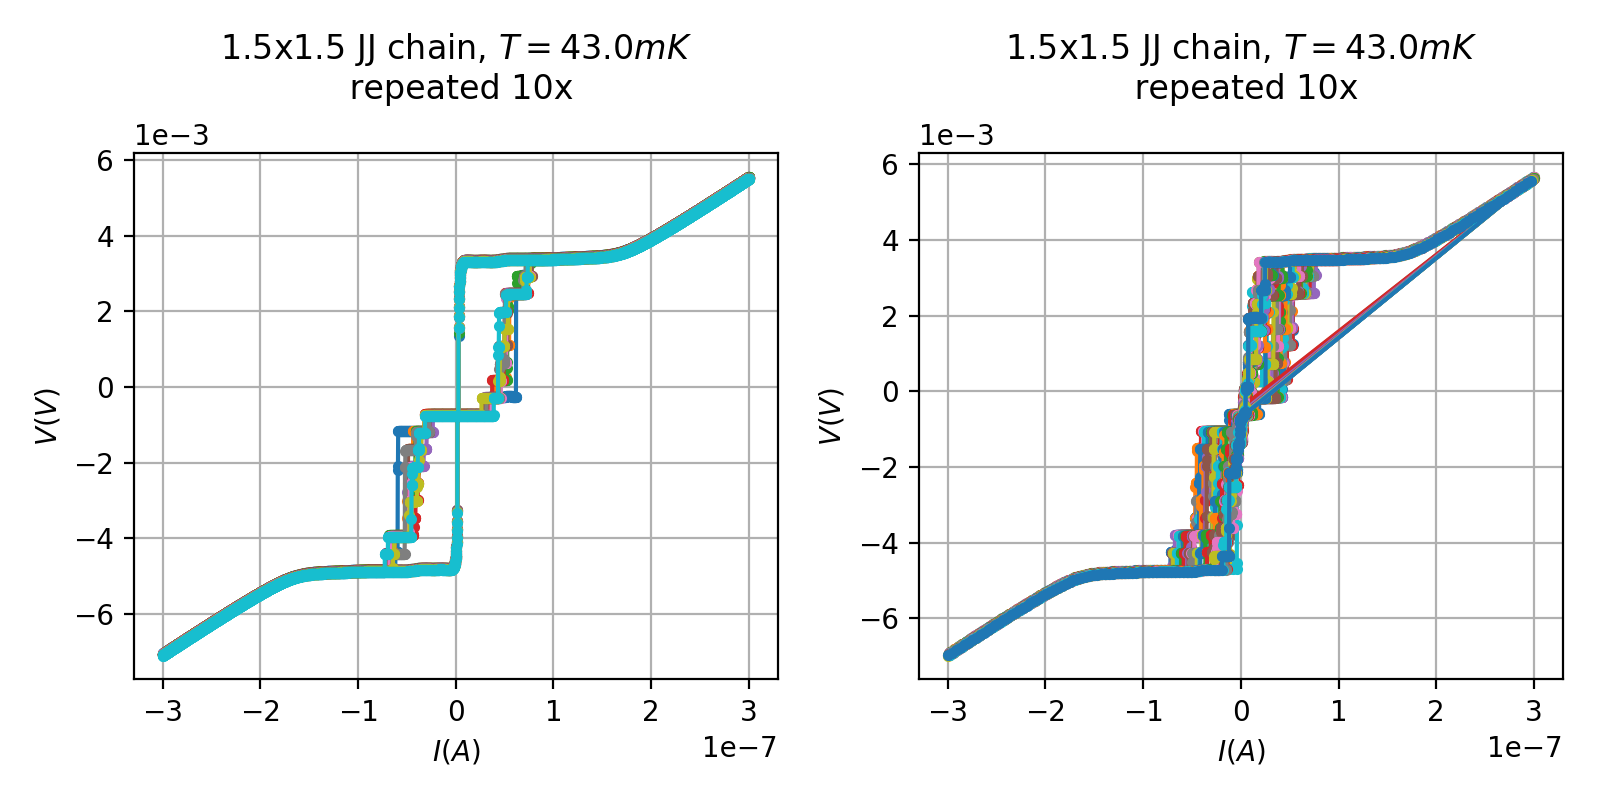

In [7]:
#demonstration about how to plot with multiple lists
SAMPLE = '74N4' #6ab,9ba
qc.config["core"]["db_location"] = r'C:\Users\racco\Documents\QCoDes\ExdData\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()

T = 43e-3
idlst = ex74N4[ex74N4['T'] == T]['ids'].tolist()[-2:]
for j,idl in enumerate(idlst):
    for i,v in enumerate(idl):
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']
        ax[j].plot(Is, Vs, '.',ls='-',label = '$T={}K$'.format(si_format(T)))#alpha=1-0.99*i ,  
        ax[j].set_xlabel('$I(A)$')
        ax[j].set_ylabel('$V(V)$')
        ax[j].set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
        ax[j].grid(True)
        ax[j].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


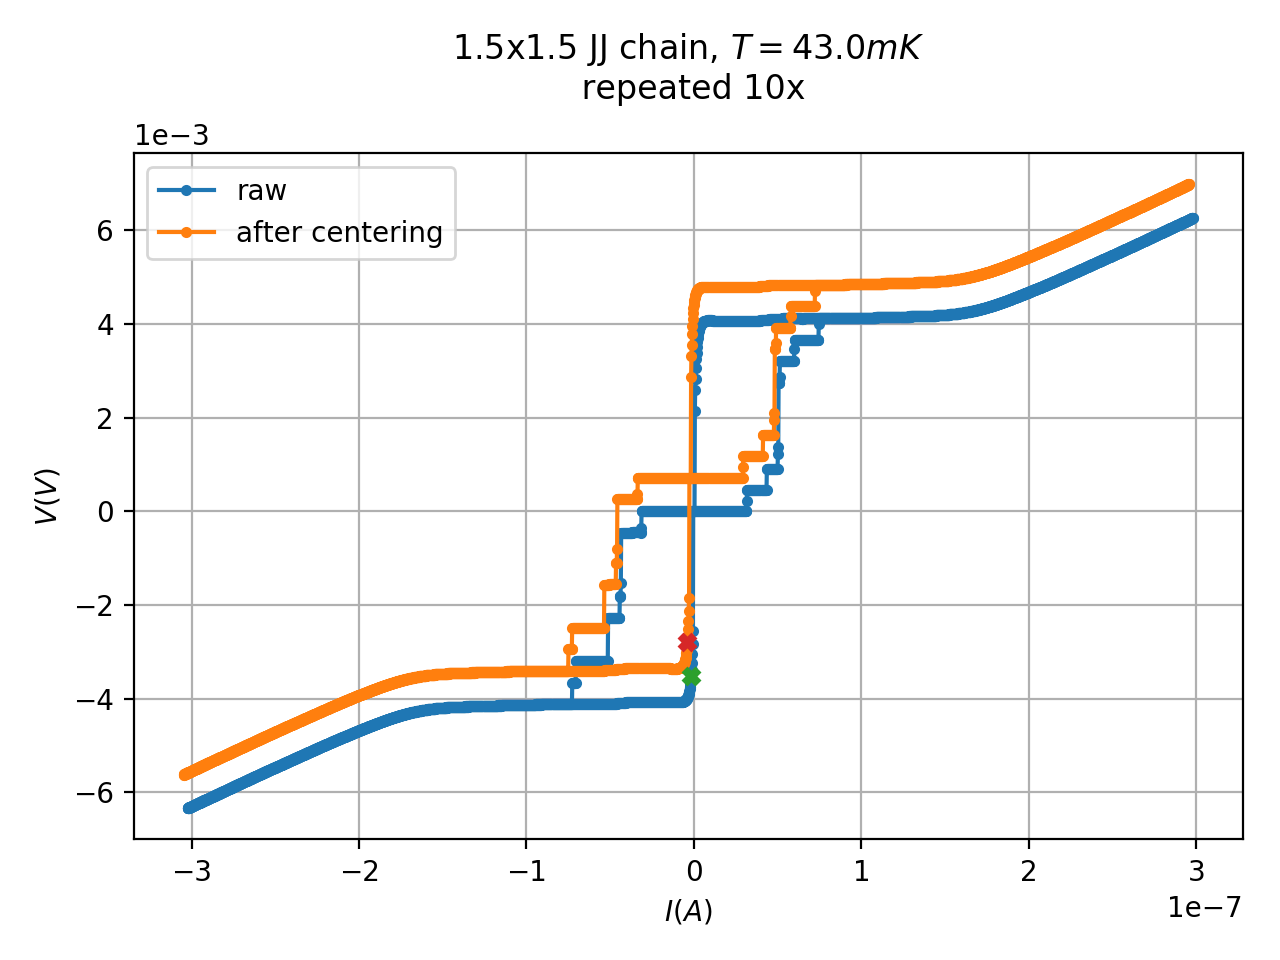

In [6]:
plt.close('all')
f,ax=plt.subplots()
# ax = ax.flatten()

T = 43e-3
for i,v in enumerate([275]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    
    Vs_off = (Vs[20]+Vs[int(len(Is)/2)])/2  
    Is_off = 2.25e-9
    Is_step= 2e-10
    Is = Is-Is_off
    Vs = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2
    
    ax.plot(Is, Vs, '.',ls='-',label = 'raw')
    ax.plot(Is-Is_off, Vs-Vs_off, '.',ls='-',label = 'after centering')
    ax.plot(Is[3], Vs[3], 'X')
    ax.plot(Is[3]-Is_off, Vs[3]-Vs_off, 'X')
    ax.set_xlabel('$I(A)$')
    ax.set_ylabel('$V(V)$')
    ax.set_title('1.5x1.5 JJ chain, $T={}K$\n repeated 10x'.format(si_format(T)), pad=20)
    ax.legend()
    ax.grid('true')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [192]:
def IVc_shift (Is, Vs, Is_off = 2.25e-9, Is_step= 2e-10):
    Is1 = Is-Is_off
    Vs1 = Vs-(Vs[int(np.ceil(Is_off/Is_step))]+Vs[int(len(Is)/2)])/2

    IVs = pd.DataFrame(data = list(zip(Is1,Vs1)), columns = ['Is', 'Vs'])
    
    ofsInd = int(np.floor(np.abs(IVs['Is'][0])/Is_step))+1
    IVs_shift = IVs.shift(periods=-1*ofsInd)
    IVs_shift = pd.concat([IVs_shift[:-1*ofsInd], IVs[0:ofsInd]], ignore_index=True)
    maxInd = IVs_shift[IVs_shift['Is'] == IVs_shift['Is'].max()].index[0]+1
    IVs_shift = pd.concat([IVs_shift[:3*maxInd], IVs_shift[-1*maxInd-1:]])
    return IVs_shift

<IPython.core.display.Javascript object>


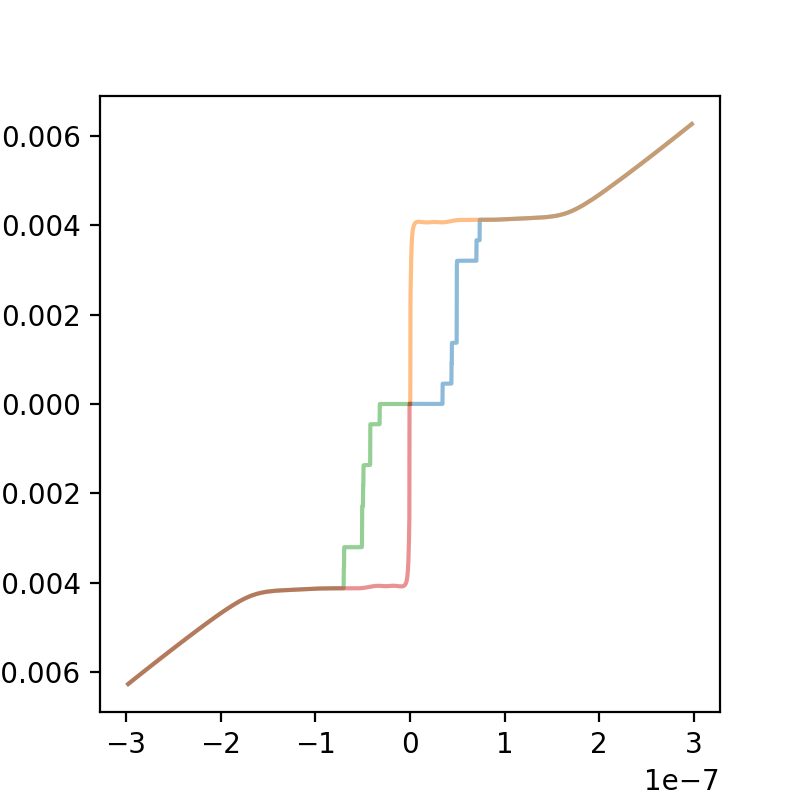

In [196]:
plt.close('all')
f,ax = plt.subplots(figsize=(4,4))

IVshift = IVc_shift(get_data_by_id(279)[0][0]['data'], 
                    get_data_by_id(279)[0][1]['data'],
                    Is_off = 2.25e-9, Is_step= 2e-10)

l = len(IVshift['Is'])

for i in [0,1,2,3]:
    ax.plot(IVshift['Is'][int(l*i/4):int(l*(i+1)/4)],
            IVshift['Vs'][int(l*i/4):int(l*(i+1)/4)],'-',alpha = 0.5)
plt.show()

### Fridge Handling

In [ ]:
key =  [ 'still',       'R','$w_{re}$','$l_{re}$',    'THK',      '$R_s$',    '$\\rho$', 'T_C']
unit=  [     'V','$\Omega$',       'm',       'm',     'm' ,'$\Omega$/sq', '$\Omega m$',   'K']
lst = [      
       [  10e-6 ,     2.91 ,  12.1e-6 ,  11.9e-6 , 52.6e-9 ,       2.959 ,  0.15564e-6 ,    0 ],
       [   1e-6 ,     159  ,   np.nan ,   np.nan ,   np.nan,      np.nan ,      np.nan ,    0 ],
      ]

thinAlDF = pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
thinAlun =   dict(zip(key, unit))

### Data visualization

<IPython.core.display.Javascript object>


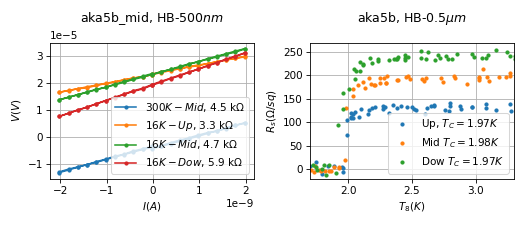

In [265]:
SAMPLE = 'aka5b' #1ab,3ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

# wid_des = 0.5e-6
# devW   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$w_{re}$'].mean()
# devL   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$l_{re}$'].mean()
# devTHK = thinAlDF[thinAlDF['$w_d$']==wid_des]['THK'].mean()

devW, devL, devTHK = 0.65e-6, 16e-6, 40e-9

labelL = ['$300K-Mid$',
          '$16K-Up$',
          '$16K-Mid$',
          '$16K-Dow$']
for i,v in enumerate([21,25,24,26]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('{}_mid, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))


labelR = [#'from 300K',14,15,18,19
          'Up, $T_C = 1.97K$',
          'Mid $T_C = 1.98K$',
          'Dow $T_C = 1.97K$']
for i,v in enumerate([27,29,31]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].set_title('{}, HB-$0.5\mu m$'.format(SAMPLE), pad=20)
ax[1].set_ylim(-20,270)
ax[1].set_xlim(1.7,3.3)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


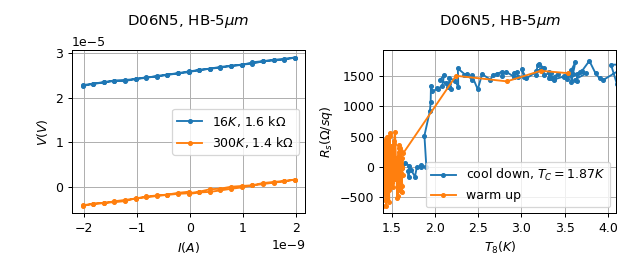

In [212]:
SAMPLE = 'D06N5' #9a7b,9b6a
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

wid_des = 5e-6
devW   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$w_{re}$'].mean()
devL   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$l_{re}$'].mean()
devTHK = thinAlDF[thinAlDF['$w_d$']==wid_des]['THK'].mean()

labelL = ['$16K$',
          '$300K$']
for i,v in enumerate([2,1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = [#'from 300K',14,15,18,19
          'cool down, $T_C = 1.87K$',
          'warm up',
          'from 300K']
factor = [1e9/2.2e6, # has R corrected due to incorrect R_bias setting when measured
          1]
for i,v in enumerate([3,4]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']*factor[i]
    Rs = R*devW/devL
    ax[1].plot(T, R, '.',ls='-', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
# ax[1].set_ylim(-100,3100)
ax[1].set_xlim(1.4,4.1)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


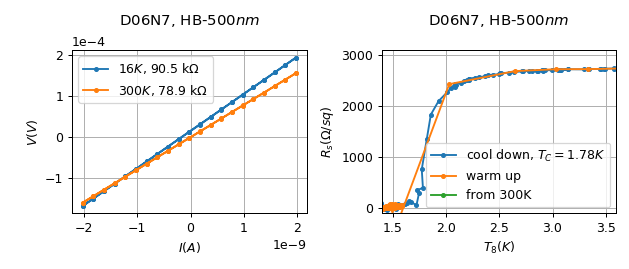

In [214]:
SAMPLE = 'D06N7' #12a11a,12b11b
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()
f,ax=plt.subplots(1,2, figsize=(7,3))

wid_des = 0.5e-6
devW   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$w_{re}$'].mean()
devL   = thinAlDF[thinAlDF['$w_d$']==wid_des]['$l_{re}$'].mean()
devTHK = thinAlDF[thinAlDF['$w_d$']==wid_des]['THK'].mean()

labelL = ['$16K$',
          '$300K$']
for i,v in enumerate([8,1]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].legend()
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))


labelR = [#'from 300K',14,15,18,19
          'cool down, $T_C = 1.78K$',
          'warm up',
          'from 300K']
for i,v in enumerate([5,6,2]):
    data = get_data_by_id(v)
    T = data[0][0]['data']
    R = data[0][1]['data']
    Rs = R*devW/devL
    ax[1].plot(T, Rs, '.',ls='-', label = labelR[i])#ls='-', alpha=1-0.99*i 

ax[1].legend()
ax[1].set_xlabel('$T_8 (K)$')
ax[1].set_ylabel('$R_s (\Omega/sq)$')
ax[1].set_title('{}, HB-${}m$'.format(SAMPLE,si_format(wid_des,0)), pad=20)
ax[1].set_ylim(-100,3100)
ax[1].set_xlim(1.4,3.6)
ax[1].grid()
ax[1].ticklabel_format(axis='none', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [282]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 13 14:53:16 2019
@author: racco
"""

# -*- coding: utf-8 -*-
"""
Created on Tue Sep 04 17:45:43 2018 @author: wsLu
"""
from math import *
import scipy.constants as const
from scipy.special import ellipk
import numpy as np
import matplotlib.pyplot as plt
import time
from si_prefix import si_format

roundN = 5

def JJparameters(RN, JJwidthUM=0.2, metalTHK=250E-10, Tc=1.34):
    
    Rs_JJ = RN * ( (JJwidthUM*1E-6 + 2*metalTHK) *JJwidthUM*1E-6 )
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN 
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM 
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
#    C0 = 1E-99
    EC0 = const.e *const.e /2 /C0
    
    freqPlasma = sqrt(2 *const.e *IAB *2*const.pi /const.h /max(C0,C_JJ)) /2/const.pi
    Q = freqPlasma*2*pi *RN *max(C0,C_JJ)
#    ParplateCap(area= JJwidthUM*JJwidthUM*1E-12 , dielecTHK=1E-9, epsilon = 9.34*8.828E-12)
#    return [IAB, EJ]
    return "[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = " + format([round(RN/1E3, roundN), round(Rs_JJ/1E3/1E-12, roundN)]) + "\n[I_AB (nA), EJ (mK)] = " + format([round(IAB/1E-9, roundN), round(EJ_JJ/1E-3/const.k, roundN)]) + "\n[C_JJQP (fF), EC (mK)] = " + format([round(C_JJ/1E-15, roundN), round(EC_JJ/1E-3/const.k, roundN)]) + "\n[C0 (fF), EC0 (mK)] = " + format([round(C0/1E-15, roundN), round(EC0/1E-3/const.k, roundN)]) + "\n[Freq_plasma (GHz))] = " + format([round(freqPlasma/1E9, roundN)])+ "\n[Q, Beta, EJ/EC] = " + format([round(Q, 1), round(Q*Q, 1), round(EJ_JJ/min(EC0,EC_JJ), 1)])
#    return RN, round(Rs_JJ/1E3/1E-12, roundN), IAB, EJ_JJ/const.k, round(C_JJ/1E-15, roundN), round(EC_JJ/1E-3/const.k, roundN), round(C0/1E-15, roundN), round(EC0/1E-3/const.k, roundN), round(freqPlasma/1E9, roundN), round(Q, 1), round(Q*Q, 1), round(EJ_JJ/min(EC0,EC_JJ), 1)

def EJEC(Rs_JJ, JJwidthUM, metalTHKUM=250E-4, Tc=1.34):
    
    RN = Rs_JJ / ( (JJwidthUM + 2*metalTHKUM) *JJwidthUM )
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN 
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM 
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e *const.e /2 /C0
    
    freqPlasma = sqrt(2 *const.e *IAB *2*const.pi /const.h /max(C0,C_JJ)) /2/const.pi
    Q = freqPlasma*2*pi *RN *max(C0,C_JJ)
    return [EJ_JJ/const.k, EC_JJ/const.k]

def CfromIVCoffset(IVCoffset):
    """
    Extract C from IV curve V offset for high Ibias branch with V = IR +e/2C
    IVCoffset: V offset from linear fits of IVC at high Ibias branch (V)
    return: C per JJ (fF/JJ)
    """
    C = const.e /2 /IVCoffset *1E15 *30 /2
#    return C
    return "C_IVCoffset/JJ (fF/JJ) = " + format(round(C, roundN))

def ParplateCap(area, dielecTHK, epsilon = 9.34*const.epsilon_0):
    """
    """
    C = epsilon *area /dielecTHK
    return C
#    return "C_parallelPlate (fF) = " + format(C *1E15)

def tiltedWashboardU(EJKBT, IbiasArr, ax):

   phi = np.arange(-0.1*np.pi, 8*np.pi, 0.025*np.pi)
   UArr=[]
   for Ibias in IbiasArr:
       U = -EJKBT*const.k*np.cos(phi) - const.h /2/np.pi /2/const.e *Ibias *phi
       UArr.append(U)

   ax.set_title('Tilted washboard', fontsize=16, fontweight='bold')
   ax.set_xlabel('$\phi$ (pi)')
   ax.set_ylabel('U (K)')

   i = 0   
   for i,U in enumerate(UArr):
       ax.plot(phi/np.pi, U/const.k,label = 'I$_b$ =' + format(si_format(IbiasArr[i])) + 'A')

   ax.text(0.82, 0.94, 'E$_J$ =' + format(si_format(EJKBT)) + 'K\n', verticalalignment='bottom', horizontalalignment='left',transform=ax.transAxes,color='black', fontsize=12)
   ax.grid(True)   
   ax.legend()


from si_prefix import si_format
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex



In [291]:
print('D079 site1: \n'+JJparameters(RN=  290e3/.5, JJwidthUM=np.sqrt( .177 *  .177), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site3: \n'+JJparameters(RN=  520e3/ 8, JJwidthUM=np.sqrt( .784 *  .263), metalTHK=250E-10, Tc=1.34)+'\n')
# print('D079 site4: \n'+JJparameters(RN=    0e3/ 8, JJwidthUM=np.sqrt( 1.55 *  1.04), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site5: \n'+JJparameters(RN=   27e3/ 8, JJwidthUM=np.sqrt( 2.25 *  1.74), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site6: \n'+JJparameters(RN= 2.15e3/.5, JJwidthUM=np.sqrt( 2.21 *  1.72), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site0: \n'+JJparameters(RN= 24.3e3/ 8, JJwidthUM=np.sqrt( 2.21 *  1.67), metalTHK=250E-10, Tc=1.34)+'\n')

D079 site1: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [580.0, 23.30382]
[I_AB (nA), EJ (mK)] = [0.55166, 13.14985]
[C_JJQP (fF), EC (mK)] = [1.56645, 593.45954]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.30279]
[Q, Beta, EJ/EC] = [511.0, 261139.1, 6.6]

D079 site3: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [65.0, 14.87825]
[I_AB (nA), EJ (mK)] = [4.92247, 117.33708]
[C_JJQP (fF), EC (mK)] = [10.3096, 90.17078]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.90449]
[Q, Beta, EJ/EC] = [171.1, 29265.6, 58.5]

D079 site5: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [3.375, 13.54702]
[I_AB (nA), EJ (mK)] = [94.80303, 2259.82525]
[C_JJQP (fF), EC (mK)] = [195.75, 4.74904]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [3.96937]
[Q, Beta, EJ/EC] = [39.0, 1519.6, 1125.8]

D079 site6: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [4.3, 16.76434]
[I_AB (nA), EJ (mK)] = [74.40936, 1773.70005]
[C_JJQP (fF), EC (mK)] = [190.06, 4.89122]
[C0 (fF), EC0 (mK)] = 

In [290]:
print('D079 site9: \n'+JJparameters(RN= 1840e3/ 8, JJwidthUM=np.sqrt( .230 *  .246), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site1: \n'+JJparameters(RN=  230e3/.5, JJwidthUM=np.sqrt( .177 *  .177), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site2: \n'+JJparameters(RN= 1710e3/ 8, JJwidthUM=np.sqrt( .259 *  .164), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site3: \n'+JJparameters(RN=  490e3/ 8, JJwidthUM=np.sqrt( .784 *  .263), metalTHK=250E-10, Tc=1.34)+'\n')
# print('D079 site4: \n'+JJparameters(RN=    0e3/ 8, JJwidthUM=np.sqrt( 1.55 *  1.04), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site5: \n'+JJparameters(RN=   75e3/ 8, JJwidthUM=np.sqrt( 2.25 *  1.74), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site6: \n'+JJparameters(RN= 2.04e3/.5, JJwidthUM=np.sqrt( 2.21 *  1.72), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site7: \n'+JJparameters(RN= 2100e3/ 8, JJwidthUM=np.sqrt( .217 *  .221), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site8: \n'+JJparameters(RN= 51.9e3/ 8, JJwidthUM=np.sqrt( 1.48 *  .977), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site0: \n'+JJparameters(RN= 24.4e3/ 8, JJwidthUM=np.sqrt( 2.21 *  1.67), metalTHK=250E-10, Tc=1.34)+'\n')

D079 site9: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [230.0, 15.74885]
[I_AB (nA), EJ (mK)] = [1.39113, 33.16048]
[C_JJQP (fF), EC (mK)] = [2.829, 328.60541]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.48083]
[Q, Beta, EJ/EC] = [321.8, 103555.1, 16.5]

D079 site1: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [460.0, 18.48234]
[I_AB (nA), EJ (mK)] = [0.69557, 16.58024]
[C_JJQP (fF), EC (mK)] = [1.56645, 593.45954]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.34]
[Q, Beta, EJ/EC] = [455.1, 207110.3, 8.3]

D079 site2: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [213.75, 11.28191]
[I_AB (nA), EJ (mK)] = [1.49689, 35.68145]
[C_JJQP (fF), EC (mK)] = [2.1238, 437.71763]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.49878]
[Q, Beta, EJ/EC] = [310.2, 96238.8, 17.8]

D079 site3: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [61.25, 14.01989]
[I_AB (nA), EJ (mK)] = [5.22384, 124.52098]
[C_JJQP (fF), EC (mK)] = [10.3096, 90.17078]
[C0 (fF), EC0 (mK)] = [

In [283]:
print('D079 site9: \n'+JJparameters(RN= 1840e3/ 8, JJwidthUM=np.sqrt( .275 *  .257), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site1: \n'+JJparameters(RN=  230e3/.5, JJwidthUM=np.sqrt( .211 *  .204), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site2: \n'+JJparameters(RN= 1710e3/ 8, JJwidthUM=np.sqrt( .264 *  .254), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site3: \n'+JJparameters(RN=  490e3/ 8, JJwidthUM=np.sqrt( .722 *  .285), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site5: \n'+JJparameters(RN=   75e3/.5, JJwidthUM=np.sqrt( .211 *  .204), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site6: \n'+JJparameters(RN= 2.04e3/.5, JJwidthUM=np.sqrt(  2.2 *   2.2), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site7: \n'+JJparameters(RN= 2100e3/.5, JJwidthUM=np.sqrt( .211 *  .204), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site8: \n'+JJparameters(RN= 51.9e3/ 8, JJwidthUM=np.sqrt( 1.04 *  1.71), metalTHK=250E-10, Tc=1.34)+'\n')
print('D079 site0: \n'+JJparameters(RN= 24.4e3/ 8, JJwidthUM=np.sqrt(  2.2 *   2.2), metalTHK=250E-10, Tc=1.34)+'\n')

D079 site9: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [230.0, 19.3125]
[I_AB (nA), EJ (mK)] = [1.39113, 33.16048]
[C_JJQP (fF), EC (mK)] = [3.53375, 263.07031]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.48083]
[Q, Beta, EJ/EC] = [321.8, 103555.1, 16.5]

D079 site1: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [460.0, 24.57206]
[I_AB (nA), EJ (mK)] = [0.69557, 16.58024]
[C_JJQP (fF), EC (mK)] = [2.1522, 431.94159]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.34]
[Q, Beta, EJ/EC] = [455.1, 207110.3, 8.3]

D079 site2: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [213.75, 17.10077]
[I_AB (nA), EJ (mK)] = [1.49689, 35.68145]
[C_JJQP (fF), EC (mK)] = [3.3528, 277.26816]
[C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
[Freq_plasma (GHz))] = [0.49878]
[Q, Beta, EJ/EC] = [310.2, 96238.8, 17.8]

D079 site3: 
[RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [61.25, 13.99262]
[I_AB (nA), EJ (mK)] = [5.22384, 124.52098]
[C_JJQP (fF), EC (mK)] = [10.2885, 90.35571]
[C0 (fF), EC0 (mK)] = [